(360, 360) (9, 362, 362)


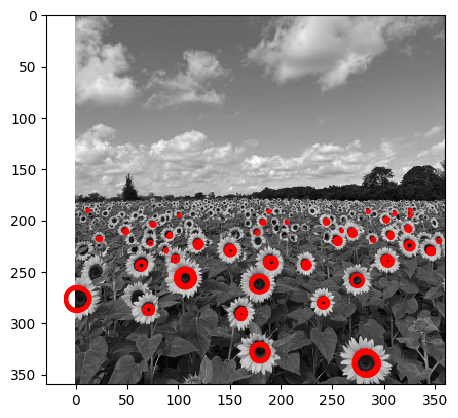

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread("the_berry_farms_sunflower_field.jpeg", cv2.IMREAD_REDUCED_COLOR_4)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float32) / 255.0 #normalizing

k = 1.414
sigma = 1.0


def LoG(sigma):
    #window size 
    hw = 3*sigma 
    # creating meshgrid
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
    # LoG filter
    log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
    return log



def LoG_convolve(img):
    log_images = [] #to store responses
    for sigma in range(1,10):
       
        filter_log = LoG(sigma) #filter generation
        image = cv2.filter2D(img,-1,filter_log) # convolving image

        image = np.pad(image,((1,1),(1,1)),'constant') 
        image = np.square(image) 
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # converting to numpy array
    return log_image_np
log_image_np = LoG_convolve(img)


def detect_blob(log_image_np):
    co_ordinates = [] #to store co ordinates
    (h,w) = img.shape #image size
    print(img.shape,log_image_np.shape)
    # finding maximum in  window
    for i in range(1,h):
        for j in range(1,w):
            
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] 
            result = np.amax(slice_img) #finding maximum
            if result >= 0.1: #threshold
                # finding co-ordinates of maximum; x: row, y: column, z: depth
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                # storing co-ordinates
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) # storing co-ordinates: (x,y,radius)
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))

fig, ax = plt.subplots()
nh,nw = img.shape
count = 0

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

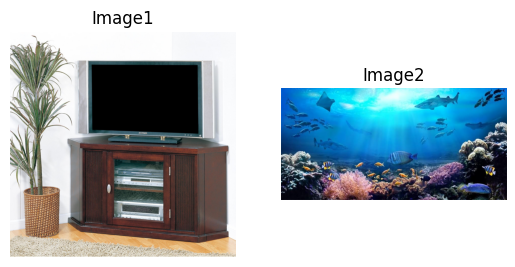

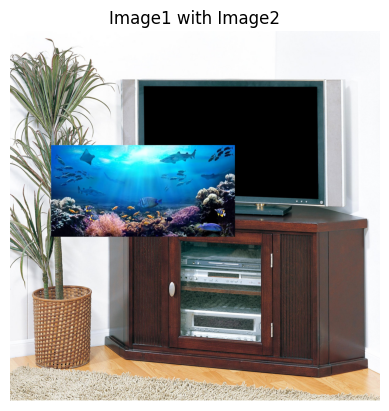

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
im1 = cv2.imread("tv.jpg")  # shape (1800, 1800, 3)
im2 = cv2.imread("ocean.jpg")  # shape (445, 894, 3)

# Display the images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.title("Image1")
plt.axis('off')  # Remove axis labels

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.title("Image2")
plt.axis('off')  # Remove axis labels

# Define the four corner points of image1
top_left = (200, 1000)
top_right = (1094, 1000)
bottom_left = (200, 1000 - 445)
bottom_right = (1094, 1000 - 445)

# Define the corner points of image2
pts1 = np.float32([[0, im2.shape[0]], [im2.shape[1], im2.shape[0]], [im2.shape[1], 0], [0, 0]])

# Create a transformation matrix to map image2 to image1
h, _ = cv2.findHomography(pts1, np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32))

# Warp image2 to image1
img2_warp = cv2.warpPerspective(im2, h, (im1.shape[1], im1.shape[0]))

# Create a mask for the image2 region
img2_mask = np.zeros_like(im1, dtype=np.uint8)
cv2.fillConvexPoly(img2_mask, np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32), (255, 255, 255))

# Invert the mask to get the non-image2 region
non_img2_mask = cv2.bitwise_not(img2_mask)

# Remove the image2 region from image1
img1_without_img2 = cv2.bitwise_and(im1, non_img2_mask)

# Combine the image2 region and the image1 without the image2 region
result = cv2.bitwise_or(img2_warp, img1_without_img2)

# Display the result
plt.figure()
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Image1 with Image2")
plt.axis('off')  # Remove axis labels
plt.show()
